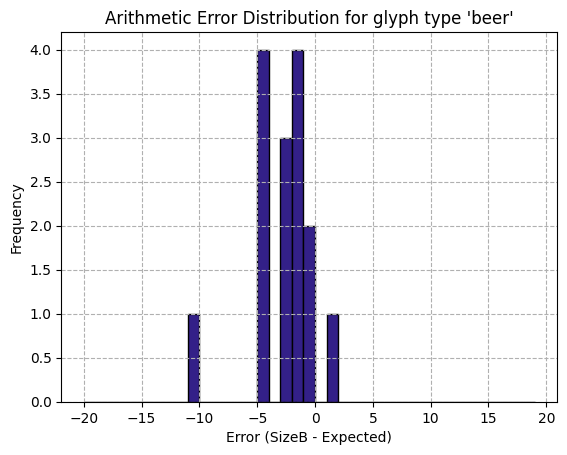

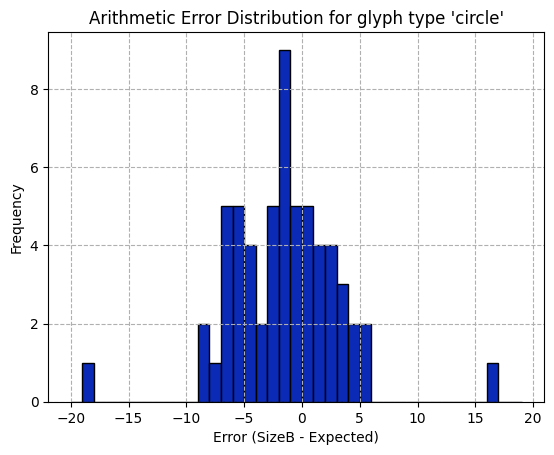

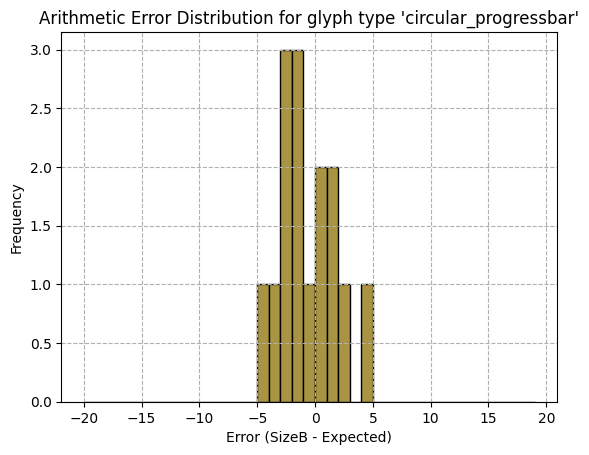

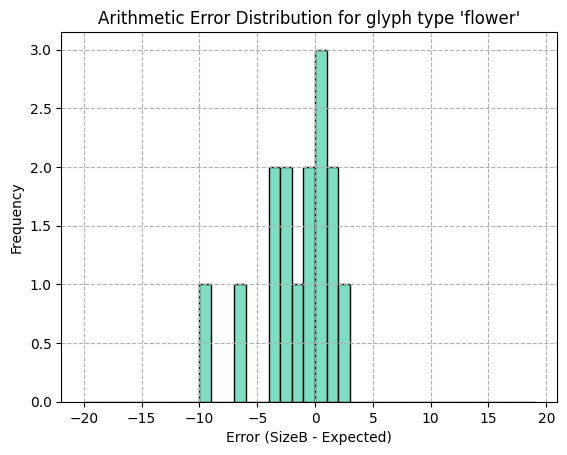

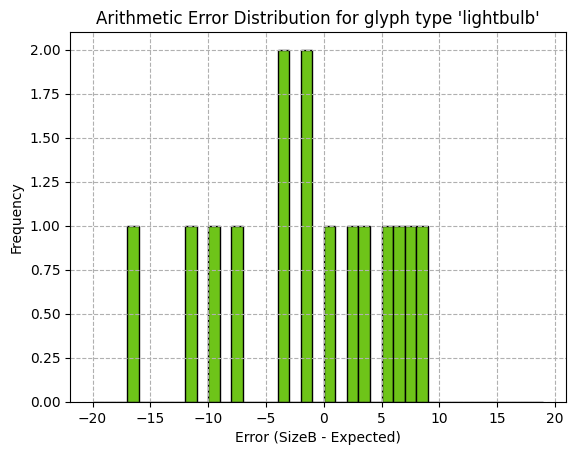

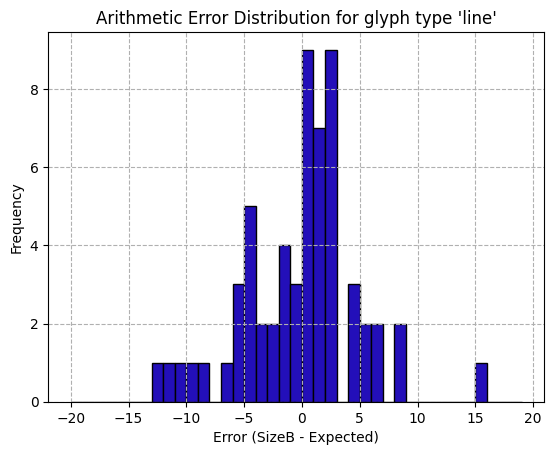

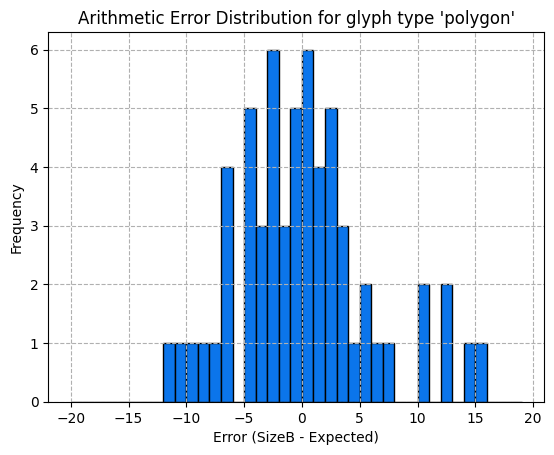

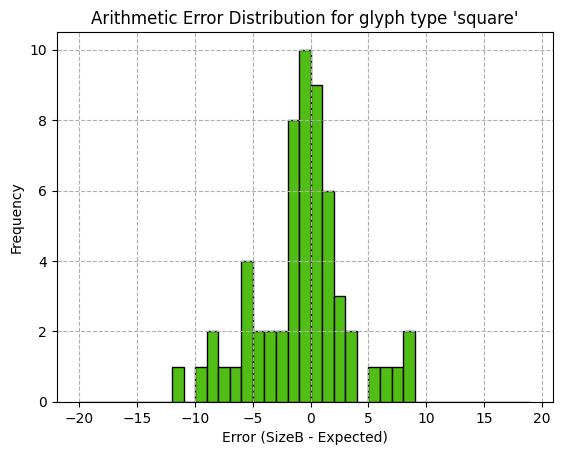

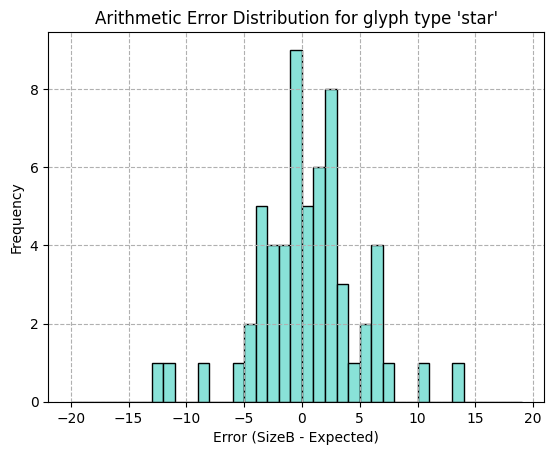

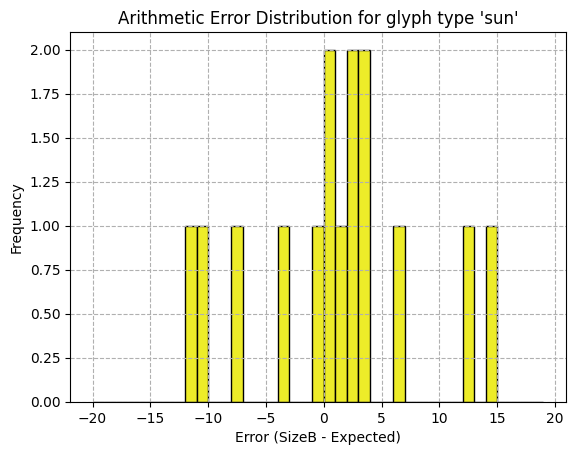

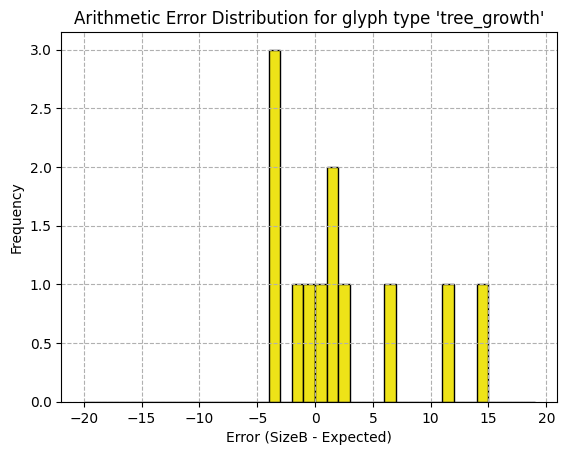

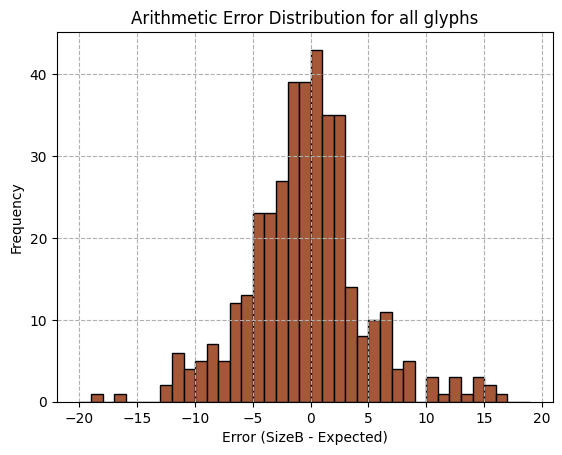

In [6]:
import numpy as np
import matplotlib.pyplot as plt

input_file = "data_sets/all_results.csv"

def open_data_file(input_file):
    with open(input_file, "r") as f:
        lines = f.readlines()
        data_lines = [line.strip().split(",") for line in lines[1:]]  # csv header
    return data_lines

data_lines = open_data_file(input_file)

# uloz typy glyphu
glyph_types = np.array([data_lines[i][1] for i in range(len(data_lines))])

# vypocet a plot aritmeticke chyby pro vsechny glyphy a pro kazdy typ glyphu zvlast
def compute_arithmetic_error():
    ar_diffs_all = [] 
    ar_diffs_by_type = {glyph_type: [] for glyph_type in np.unique(glyph_types)}
    for i in range(len(data_lines)):
        A = int(data_lines[i][2])  
        B = int(data_lines[i][3])
        C = int(data_lines[i][4])
        expected = (A + C) / 2
        diff = B - expected
        ar_diffs_all.append(diff)

        glyph_type = data_lines[i][1]
        ar_diffs_by_type[glyph_type].append(diff)

    return ar_diffs_all, ar_diffs_by_type
    
ar_diffs_all, ar_diffs_by_type = compute_arithmetic_error()
# Plot pro kazdy typ glyphu
for glyph_type, diffs in ar_diffs_by_type.items():
    plt.figure()
    plt.hist(diffs, bins=np.arange(-20, 20, 1), edgecolor='black', color=np.random.rand(3))
    plt.xlabel("Error (SizeB - Expected)")
    plt.ylabel("Frequency")
    plt.title(f"Arithmetic Error Distribution for glyph type '{glyph_type}'")
    plt.grid(linestyle='--')
    plt.show()

# Plot pro vsechny glyphy dohromady
plt.figure()
plt.hist(ar_diffs_all, bins=np.arange(-20, 20, 1), edgecolor='black', color=np.random.rand(3))
plt.xlabel("Error (SizeB - Expected)")
plt.ylabel("Frequency")
plt.title("Arithmetic Error Distribution for all glyphs")
plt.grid(linestyle='--')
plt.show()


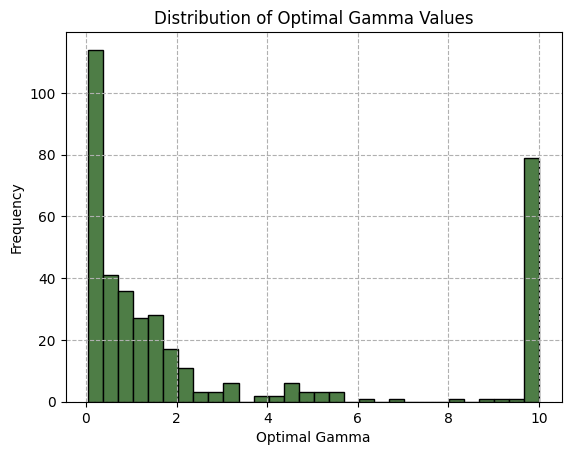

Average gamma: 2.98031 with median: 1.09252
Avg error: 0.00051


In [7]:
# gamma correction
# jednoparametrovy model
# P = S^gamma
# |S2^gamma - Sx^gamma| = |Sx^gamma - S1^gamma|
# chci aby na skale vnimani (osa y) byla chyba co nejmensi, aby platilo, ze B lezi mezi A a C
# minimalizuji chybu diff = B^gamma - ((A^gamma + C^gamma) / 2)
# muzu si vyzkouset ruzne hodnoty gamma a najit tu, ktera minimalizuje chybu    

EPS = 1e-6
MIN = 0.05
MAX = 10.0
N = 4000

def my_gamma(A, B, C):
    a = np.clip(A / 100.0, EPS, 1.0 - EPS)
    b = np.clip(B / 100.0, EPS, 1.0 - EPS)
    c = np.clip(C / 100.0, EPS, 1.0 - EPS)

    gammas = np.linspace(MIN, MAX, N)
    errors = []
    errors = np.abs(b**gammas - (a**gammas + c**gammas) / 2)
    i = np.argmin(errors)
    
    return gammas[i], errors[i]

# manualni odhad gamma
def process_all_gammas():
    gammas = []
    errors = []
    for i in range(len(data_lines)):
        gamma, error = my_gamma(float(data_lines[i][2]), float(data_lines[i][3]), float(data_lines[i][4]))
        gammas.append(gamma)
        errors.append(error)

    return gammas, errors

gammas, errors = process_all_gammas()

plt.hist(gammas, bins=30, edgecolor='black', color=np.random.rand(3))
plt.xlabel("Optimal Gamma")
plt.ylabel("Frequency")
plt.title("Distribution of Optimal Gamma Values")
plt.grid(linestyle='--')
plt.show()

print(f"Average gamma: {np.mean(gammas):.5f} with median: {np.median(gammas):.5f}")
print(f"Avg error: {np.mean(errors):.5f}")

Glyph                     N     MAE        Gamma     
------------------------------------------------------------
All                       390   0.0390     0.99040   
Beer                      15    0.0220     0.45256   
Lightbulb                 15    0.0589     1.10885   
Circle                    60    0.0352     0.82906   
Sun                       15    0.0456     0.65305   
Polygon                   60    0.0439     1.20439   
Circular_progressbar      15    0.0213     0.93589   
Tree_growth               15    0.0530     2.62931   
Star                      60    0.0320     1.11547   
Square                    60    0.0353     0.92935   
Line                      60    0.0366     0.98910   
Flower                    15    0.0174     0.67109   


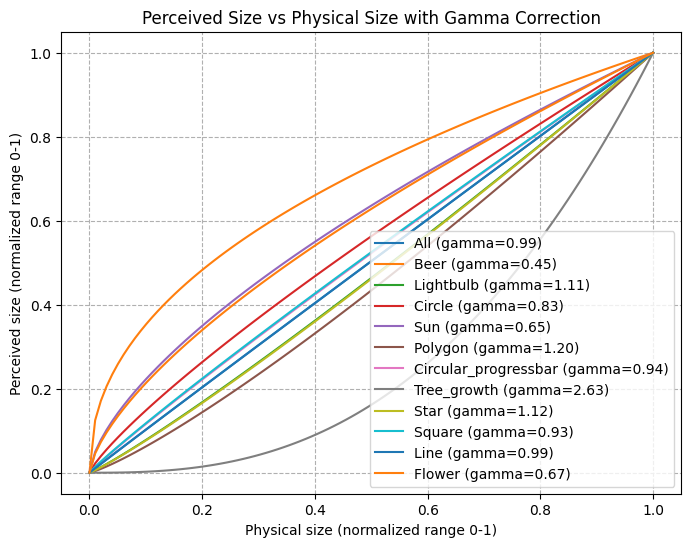

In [8]:
from scipy.optimize import least_squares
import numpy as np

EPS = 1e-6
MIN, MAX = 0.05, 5.0       
FILTER = False

A = np.array([float(data_lines[i][2]) for i in range(len(data_lines))])
B = np.array([float(data_lines[i][3]) for i in range(len(data_lines))])
C = np.array([float(data_lines[i][4]) for i in range(len(data_lines))])

def normalize_data(x):
    return np.clip(x/100.0, EPS, 1.0-EPS)

a = normalize_data(A)
b = normalize_data(B)
c = normalize_data(C)

if FILTER:
    low = np.minimum(a, c)
    high = np.maximum(a, c)
    idx = (b >= low) & (b <= high)
    a, b, c, glyph_types = a[idx], b[idx], c[idx], glyph_types[idx]

def predict_b_gamma(gamma, a, c):
    middle = (a**gamma + c**gamma) / 2
    return middle ** (1.0/gamma)

def residuals_stimulus(gamma, a, b, c):
    g = gamma.ravel()[0]
    return predict_b_gamma(g, a, c) - b 

def ls_find_gamma_stimulus(a, b, c):
    res = least_squares(residuals_stimulus, x0=1.0, bounds=(MIN, MAX), args=(a, b, c))
    return float(res.x[0])

def MAE(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def stats_per_glyph_type(a, b, c, T):
    rows = []
    g_all= ls_find_gamma_stimulus(a, b, c)
    mae_all = MAE(b, predict_b_gamma(g_all, a, c))
    rows.append(("All", len(b), mae_all, g_all))
    for t in set(glyph_types):
        idx = (glyph_types == t)
        a_t= a[idx]
        b_t= b[idx]
        c_t= c[idx]
        g_t = ls_find_gamma_stimulus(a_t, b_t, c_t)
        mae_t = MAE(b_t, predict_b_gamma(g_t, a_t, c_t))
        rows.append((t.capitalize(), len(b_t), mae_t, g_t))
    return rows

def print_table(rows):
    print(f"{'Glyph':<25} {'N':<5} {'MAE':<10} {'Gamma':<10}")
    print("-" * 60)
    for row in rows:
        print(f"{row[0]:<25} {row[1]:<5} {row[2]:<10.4f} {row[3]:<10.5f}")

rows = stats_per_glyph_type(a, b, c, glyph_types)
print_table(rows)

plt.figure(figsize=(8, 6))
x = np.linspace(0, 1, 100)
for row in rows:
    gamma = row[3]
    y = x ** gamma
    plt.xlabel("Physical size (normalized range 0-1)")
    plt.ylabel("Perceived size (normalized range 0-1)")
    plt.title("Perceived Size vs Physical Size with Gamma Correction")
    plt.grid(linestyle="--")
    plt.plot(x, y, label=f"{row[0]} (gamma={gamma:.2f})")
    plt.legend()
